# Import Library

In [4]:
import json 
import pandas as pd
import numpy as np
from pathlib import Path
import PIL
from PIL import Image
import os, time, random
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh
from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import torch
from IPython.display import Image  # to display images
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(1) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.9.0+cu111 _CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11019MB, multi_processor_count=68)


## Detection 

### Create Inference Folder

In [11]:
name = ['0','01','02','03','04','05','06','07','08','09']
for n in name:
    if not os.path.exists('/media/tohn/SSD/YOLOv4/model_p5/inference-yolov4-p5/PCI{}'.format(n)):
        os.makedirs('/media/tohn/SSD/YOLOv4/model_p5/inference-yolov4-p5/PCI{}'.format(n))

In [9]:
## work on yolov5 directory
os.chdir('/home/kannika/ScaledYOLOv4/')

In [10]:
!pwd

/home/kannika/ScaledYOLOv4


> ## Predict with **Confident ScoreThr == 0.0 - 1.0**

In [1]:
import cv2

In [50]:
# ###  --iou-thres 0.45 **** -------------Seting -------****
# ## test set 10 Images
# threshold_score = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# name = ['0','01','02','03','04','05','06','07','08','09']
# for i, j in zip(threshold_score, name):
#     !python detect.py --weights /media/tohn/SSD/YOLOv4/model_p5/exp0_yolov4-p5-results/weights/last_yolov4-p5-results.pt --img-size 640 --conf-thres {i} --iou-thres 0.5 --device 0 --source /media/tohn/SSD/ProstateCancer/test --save-txt --output /media/tohn/SSD/YOLOv4/model_p5/inference-yolov4-p5/PCI{j}

### Load  label .txt to .CSV

In [37]:
# ##  get label predict in Directory 
# ## convert .txt to .csv 
# import glob
# import csv

# def create_file(name):
#     ## get label predict in Directory
#     PATH = f'/media/tohn/SSD/YOLOv4/model_p5/inference-yolov4-p5/PCI{name}'
#     path_txt = glob.glob(f"{PATH}/prostate_custom_*.txt")
#     os.chdir(PATH)
#     for p in path_txt:
#         with open(p, 'r') as in_file:
#             stripped = (line.strip() for line in in_file)
#             lines = (line.split(" ") for line in stripped if line)
#             name = p.split('.')[0]
#             name = name +'.csv'
#             with open(name, 'w') as out_file:
#                 writer = csv.writer(out_file)
#                 writer.writerow(('class', 'x-center', 'y-center', 'w', 'h'))
#                 writer.writerows(lines)   

In [47]:
# name = ['0','01','02','03','04','05','06','07','08','09']
# path_  = list()
# for n in name:
#     path = f'/media/tohn/SSD/YOLOv4/model_p5/inference-yolov4-p5/PCI{n}'
#     path_.append(path)
    
# print(len(path_))
# path_

In [34]:
name=0
PATH = f'/media/tohn/SSD/YOLOv4/model_p5/inference-yolov4-p5/PCI{name}'
PATH
path_txt = glob.glob(f"{PATH}/prostate_custom_*.txt")
path_txt
os.chdir(PATH)
for p in path_txt:
    with open(p, 'r') as in_file:
        stripped = (line.strip() for line in in_file)
        lines = (line.split(" ") for line in stripped if line)
        name = p.split('.')[0]
        name = name +'.csv'
        with open(name, 'w') as out_file:
            writer = csv.writer(out_file)
            writer.writerow(('class', 'x-center', 'y-center', 'w', 'h'))
            writer.writerows(lines)   

In [42]:
##### Concat CSV to 1 file
def concat_df(PATH, name_i) : ##path/to/lable/.csv/  ## name/scorethr/ 
    path_csv = glob.glob(f"{PATH}/prostate_custom_*.csv")
    df_  = list()
    for c in path_csv:
        df = pd.read_csv(c)
        image = c.split('/')[-1]
        image = image.split('.')[0]+'.jpg'
        df['fileName'] = image
        df_.append(df)
    all_csv = pd.concat(df_ ,axis=0).reset_index(drop=True)
    all_csv.to_csv(f'{PATH}/prostate_custom_{name_i}.csv')
    ## Return/csv/table/all/score/thr
    return all_csv 

In [41]:
f'{PATH}prostate_custom_{name_i}.csv'

'/media/tohn/SSD/YOLOv4/model_p5/inference-yolov4-p5/PCI0prostate_custom_0.csv'

In [44]:
name_i='PCI0'
DataFrame0 = concat_df(PATH, name_i)
print(DataFrame0.shape)
DataFrame0.head()

(3000, 6)


,class,x-center,y-center,w,h,fileName
0,0,0.530201,0.514583,0.042506,0.062500,prostate_custom_191.jpg
1,0,0.543065,0.580556,0.063758,0.044444,prostate_custom_191.jpg
2,0,0.491051,0.567361,0.038031,0.040278,prostate_custom_191.jpg
3,0,0.447987,0.536806,0.043624,0.059722,prostate_custom_191.jpg
4,0,0.537472,0.528472,0.054810,0.062500,prostate_custom_191.jpg


In [7]:
# DataFrame0 = pd.read_csv('/media/tohn/SSD/YOLOv5/result/prostate/scorethr_e400/PCI0/labels/prostate_custom_PCI0.csv')
# print(DataFrame0.shape)
# DataFrame0

### Rebox: Easily convert between bounding box formats

In [48]:
from rebox import BBox
from rebox.formats import yolo, coco, pascal

# DataFrame0 = all_csv
def rebox(DataFrame0) :  ## DataFrame0 from concat_df
    Opath = '/media/tohn/SSD/ProstateCancer/test/'
    ###เก็บค่า shape imagesของ GT Bbox
    image_width_ = list()  #-- shape[1]
    image_height_ = list()  #-- shape[0]
    # image_height = 640 # pixels
    # image_width = 640 # pixels
    x_min_ = list()
    y_min_ = list()
    x_MAX_= list()
    y_MAX_ = list()

    for i in range(len(DataFrame0)) :
        x_Center = DataFrame0['x-center'][i] 
        y_Center = DataFrame0['y-center'][i]
        width = DataFrame0['w'][i] 
        height  = DataFrame0['h'][i]
        img_path_i = Opath+DataFrame0.fileName[i]
        image_width = cv2.imread(img_path_i).shape[1]
        image_height = cv2.imread(img_path_i).shape[0]
        yolo_bbox = BBox([x_Center, y_Center, width, height], yolo) # using built-in 'yolo_format'
        coco_bbox = yolo_bbox.as_format(coco, image_width, image_height) # to convert to built-in format 'coco'
        pascal_bbox = coco_bbox.as_format(pascal)
        bbox = pascal_bbox.value
        x_min = bbox[0]
        x_min_.append(x_min)
        y_min = bbox[1]
        y_min_.append(y_min)
        x_MAX = bbox[2]
        x_MAX_.append(x_MAX)
        y_MAX = bbox[3]
        y_MAX_.append(y_MAX)

    DataFrame0['pred_xmin'] = x_min_
    DataFrame0['pred_ymin'] = y_min_
    DataFrame0['pred_xmax'] = x_MAX_
    DataFrame0['pred_ymax'] = y_MAX_

    return DataFrame0 

In [49]:
table = rebox(DataFrame0)
print(table.shape)
table.head()

(3000, 10)


,class,x-center,y-center,w,h,fileName,pred_xmin,pred_ymin,pred_xmax,pred_ymax
0,0,0.530201,0.514583,0.042506,0.062500,prostate_custom_191.jpg,454.9566,347.976,493.0410,392.976
1,0,0.543065,0.580556,0.063758,0.044444,prostate_custom_191.jpg,457.0128,401.976,513.9606,434.016
2,0,0.491051,0.567361,0.038031,0.040278,prostate_custom_191.jpg,421.9680,393.984,456.0294,423.000
3,0,0.447987,0.536806,0.043624,0.059722,prostate_custom_191.jpg,381.0228,364.968,420.0012,408.024
4,0,0.537472,0.528472,0.054810,0.062500,prostate_custom_191.jpg,456.0294,357.984,505.0206,402.984


> #### 1. Get Predict Bbox to 1 row

In [54]:
#รวม prediction box ใน 1 image 
def Get_1boxPre(table) :
    a = table.groupby(['fileName']).count()
    a = table.iloc[:,0]
    aa_ =[]
    for  i in  range(len(a)):
        aa = a[i]
        aa_.append(aa)
    name = sorted(list(set(table['fileName'])))

    fileName_, x1s_, y1s_, x2s_, y2s_, =[], [], [], [], []
    for j in name:
        x1_, y1_, x2_, y2_ = [], [], [], []
        fileName_.append(j)
        for i in range(len(table)):
            fileName = table['fileName'][i]
            if fileName == j:
                x1_.append(table['pred_xmin'][i])
                y1_.append(table['pred_ymin'][i])
                x2_.append(table['pred_xmax'][i])
                y2_.append(table['pred_ymax'][i])

        x1s_.append(x1_)
        y1s_.append(y1_)
        x2s_.append(x2_)
        y2s_.append(y2_)

    result = {'fileName': fileName_, 'pred_xmin': x1s_,'pred_ymin': y1s_,'pred_xmax': x2s_,'pred_ymax': y2s_}
    result = pd.DataFrame(result, columns=['fileName', 'pred_xmin','pred_ymin','pred_xmax','pred_ymax'])

    count_ = list()
    for k in range(len(result)):
        count = len(result['pred_xmin'][k])
        count_.append(count)

    result['pred_count'] = count_

    return result 

In [55]:
table1 = Get_1boxPre(DataFrame0)
print(table1.shape)
table1.head()

(10, 6)


,fileName,pred_xmin,pred_ymin,pred_xmax,pred_ymax,pred_count
0,prostate_custom_191.jpg,"[454.9566, 457.0128, 421.968, 381.0228, 456.02...","[347.976, 401.976, 393.984, 364.968, 357.984, ...","[493.041, 513.9606, 456.0294, 420.0012, 505.02...","[392.976, 434.016, 423.0, 408.024, 402.984, 42...",300
1,prostate_custom_194.jpg,"[386.9824, 461.9776, 460.0064, 450.9568, 398.0...","[394.0265, 275.9988, 280.9737, 324.0174, 379.9...","[446.0288, 514.0352, 512.96, 496.0256, 464.038...","[448.0294, 303.9736, 348.0267, 377.0109, 442.9...",300
2,prostate_custom_196.jpg,"[585.984, 622.0032, 599.9616, 571.0208, 0.9856...","[518.9758, 517.9664, 458.9886, 497.9947, 364.9...","[653.9904, 657.0368, 653.9904, 665.9968, 97.03...","[556.9725, 556.0352, 508.0166, 564.9756, 405.9...",300
3,prostate_custom_197.jpg,"[382.9705, 498.9625, 490.0125, 502.0055, 369.9...","[379.008, 294.984, 292.032, 300.024, 364.968, ...","[426.02, 515.9675, 521.964, 521.964, 448.037, ...","[428.976, 328.032, 329.976, 330.984, 434.016, ...",300
4,prostate_custom_198.jpg,"[517.9836, 436.0038, 518.967, 112.0182, 791.99...","[384.984, 420.984, 436.032, 193.032, 469.008, ...","[553.0284, 477.0384, 549.9888, 149.0298, 830.9...","[409.968, 439.992, 473.976, 211.032, 508.032, ...",300


In [57]:
len(table1['fileName'].tolist())

10

> #### 2. Get Actual Bbox to 1 row

In [58]:
#รวม actual box ใน 1 image 
def Get_1boxAct(test) :
    a = test.groupby(['image']).count()
    a = a.iloc[:,0]
    aa_ = []
    for  i in  range(len(a)):
        aa = a[i]
        aa_.append(aa)
    name = sorted(list(set(test['image'])))
    path = sorted(list(set(test['img_path'])))

    fileName_, x1s_, y1s_, x2s_, y2s_ = [], [], [], [], []
    for j in name:
        x1_, y1_, x2_, y2_ = [], [], [], []
        fileName_.append(j)
        for i in range(len(test)):
            fileName = test['image'][i] 
            if fileName == j:
                x1_.append(test['xmin'][i])
                y1_.append(test['ymin'][i])
                x2_.append(test['xmax'][i])
                y2_.append(test['ymax'][i])

        x1s_.append(x1_)
        y1s_.append(y1_)
        x2s_.append(x2_)
        y2s_.append(y2_)
        #Path_.append(test['img_path'][i])

    test_ = {'fileName': fileName_, 'Path':path, 'gt_xmin': x1s_,'gt_ymin': y1s_,'gt_xmax': x2s_,'gt_ymax': y2s_, 'count': aa_}
    test_ = pd.DataFrame(test_, columns=['fileName', 'Path', 'gt_xmin','gt_ymin','gt_xmax','gt_ymax', 'count'])

#     print(test_.shape)
#     test_.head()
    return test_

In [59]:
test = pd.read_csv('/media/tohn/SSD/ProstateCancer/prostate_test_mapping.csv')
test_ = Get_1boxAct(test)
print(test_.shape)
test_.head()

(10, 7)


,fileName,Path,gt_xmin,gt_ymin,gt_xmax,gt_ymax,count
0,prostate_custom_191.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,"[468.0, 470.0, 351.0]","[309.0, 385.0, 374.0]","[549.0, 551.0, 390.0]","[367.0, 411.0, 432.0]",3
1,prostate_custom_194.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,"[385.0, 512.0]","[392.0, 362.0]","[442.0, 544.0]","[452.0, 403.0]",2
2,prostate_custom_196.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,[572.0],[408.0],[614.0],[501.0],1
3,prostate_custom_197.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,[437.0],[382.0],[518.0],[430.0],1
4,prostate_custom_198.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,"[510.0, 527.0]","[436.0, 362.0]","[544.0, 553.0]","[475.0, 404.0]",2


In [60]:
def map_table(test_, result_rebox) :## Paremeter -->>> test_ == test dataframe, result == predict dataframe 
    ## merge table 
    df_merge = pd.merge(test_, result_rebox, how="outer", on=["fileName", "fileName"])

    return df_merge

In [63]:
#tb = df_merge
def fill_(df_merge):
    columns_ = ['pred_xmin', 'pred_ymin', 'pred_xmax', 'pred_ymax']
    for col in columns_: 
        for row in df_merge.loc[df_merge[col].isnull(), col].index:   ##for columns type is list 
            df_merge.at[row, col] = []

    for row in df_merge.loc[df_merge.pred_count.isnull(), 'pred_count'].index: ##for columns type is float
        df_merge.at[row, 'pred_count'] = 0

    return df_merge

In [64]:
df_merge = map_table(test_, table1)
result = fill_(df_merge)
print(result.shape)
result

(10, 12)


,fileName,Path,gt_xmin,gt_ymin,gt_xmax,gt_ymax,count,pred_xmin,pred_ymin,pred_xmax,pred_ymax,pred_count
0,prostate_custom_191.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,"[468.0, 470.0, 351.0]","[309.0, 385.0, 374.0]","[549.0, 551.0, 390.0]","[367.0, 411.0, 432.0]",3,"[454.9566, 457.0128, 421.968, 381.0228, 456.02...","[347.976, 401.976, 393.984, 364.968, 357.984, ...","[493.041, 513.9606, 456.0294, 420.0012, 505.02...","[392.976, 434.016, 423.0, 408.024, 402.984, 42...",300
1,prostate_custom_194.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,"[385.0, 512.0]","[392.0, 362.0]","[442.0, 544.0]","[452.0, 403.0]",2,"[386.9824, 461.9776, 460.0064, 450.9568, 398.0...","[394.0265, 275.9988, 280.9737, 324.0174, 379.9...","[446.0288, 514.0352, 512.96, 496.0256, 464.038...","[448.0294, 303.9736, 348.0267, 377.0109, 442.9...",300
2,prostate_custom_196.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,[572.0],[408.0],[614.0],[501.0],1,"[585.984, 622.0032, 599.9616, 571.0208, 0.9856...","[518.9758, 517.9664, 458.9886, 497.9947, 364.9...","[653.9904, 657.0368, 653.9904, 665.9968, 97.03...","[556.9725, 556.0352, 508.0166, 564.9756, 405.9...",300
3,prostate_custom_197.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,[437.0],[382.0],[518.0],[430.0],1,"[382.9705, 498.9625, 490.0125, 502.0055, 369.9...","[379.008, 294.984, 292.032, 300.024, 364.968, ...","[426.02, 515.9675, 521.964, 521.964, 448.037, ...","[428.976, 328.032, 329.976, 330.984, 434.016, ...",300
4,prostate_custom_198.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,"[510.0, 527.0]","[436.0, 362.0]","[544.0, 553.0]","[475.0, 404.0]",2,"[517.9836, 436.0038, 518.967, 112.0182, 791.99...","[384.984, 420.984, 436.032, 193.032, 469.008, ...","[553.0284, 477.0384, 549.9888, 149.0298, 830.9...","[409.968, 439.992, 473.976, 211.032, 508.032, ...",300
5,prostate_custom_200.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,[403.0],[208.0],[462.0],[240.0],1,"[547.008, 759.9872, 751.0272, 428.0192, 542.97...","[463.0262, 535.9914, 556.9725, 203.9709, 458.9...","[560.9856, 819.0336, 827.008, 475.9552, 559.01...","[479.0324, 596.988, 627.991, 231.0084, 476.004...",300
6,prostate_custom_201.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,"[413.0, 464.0]","[291.0, 294.0]","[445.0, 501.0]","[319.0, 327.0]",2,"[461.0358, 404.982, 457.9962, 384.9564, 442.97...","[311.976, 292.032, 291.024, 328.968, 292.968, ...","[505.0206, 452.9898, 504.0372, 425.0076, 521.0...","[360.0, 322.992, 327.024, 362.016, 366.984, 34...",300
7,prostate_custom_203.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,"[437.0, 420.0, 411.0]","[313.0, 386.0, 250.0]","[475.0, 461.0, 458.0]","[359.0, 408.0, 293.0]",3,"[444.994, 423.9615, 436.044, 436.044, 437.0285...","[315.0, 391.032, 266.976, 240.984, 246.024, 28...","[510.9555, 458.956, 455.018, 461.999, 463.968,...","[356.976, 408.024, 300.024, 265.968, 283.968, ...",300
8,prostate_custom_206.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,[371.0],[352.0],[429.0],[404.0],1,"[369.0432, 350.9844, 402.0318, 388.9794, 625.9...","[354.024, 337.968, 649.008, 347.976, 181.008, ...","[429.0306, 441.0102, 458.9796, 448.9668, 642.9...","[391.032, 405.0, 697.968, 391.032, 204.984, 70...",300
9,prostate_custom_207.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,"[363.0, 503.0, 447.0]","[312.0, 322.0, 407.0]","[410.0, 532.0, 512.0]","[372.0, 372.0, 439.0]",3,"[441.9936, 364.0368, 381.0228, 447.0, 349.0176...","[406.008, 318.024, 264.024, 384.984, 310.032, ...","[515.0334, 408.0216, 419.0178, 517.9836, 429.0...","[436.968, 366.984, 307.008, 450.0, 382.968, 10...",300


# Prediction function

In [65]:
def IoUfunction(res):
    pre_ ,  gt_ = [], []
    i = 0

    for j in range(len(res['pred_xmin'].tolist()[i])):
        xmin_pre = int(res['pred_xmin'].tolist()[i][j])
        ymin_pre = int(res['pred_ymin'].tolist()[i][j])
        xmax_pre = int(res['pred_xmax'].tolist()[i][j])
        ymax_pre = int(res['pred_ymax'].tolist()[i][j])
        pre = [xmin_pre, ymin_pre, xmax_pre, ymax_pre]
        pre_.append(pre)

    for j in range(len(res['gt_xmin'].tolist()[i])):
        xmin_gt= int(res['gt_xmin'].tolist()[i][j])
        ymin_gt = int(res['gt_ymin'].tolist()[i][j])
        xmax_gt= int(res['gt_xmax'].tolist()[i][j])
        ymax_gt = int(res['gt_ymax'].tolist()[i][j])
        gt = [xmin_gt, ymin_gt, xmax_gt, ymax_gt]
        gt_.append(gt)

    #ป้องกัน ไม่มีผล predict
    if pre_ == []:   ##if pre_ == np.NaN ## check NaN value()
        iou_pred = torch.tensor([0], dtype=torch.float)
        iou_gt = torch.tensor([0], dtype=torch.float)
    else:
        box1 = torch.tensor(pre_, dtype=torch.float)
        box2 = torch.tensor(gt_, dtype=torch.float)
        iou_pred = bops.box_iou(box1, box2)
        iou_gt = bops.box_iou(box2, box1)

    return iou_pred, iou_gt

In [66]:
import torch
import torchvision.ops.boxes as bops

def EvaluationTeble(result, threshold_iou):
    IoU_pred, IoUavg_img_ = [], []
    fileName = result['fileName'].tolist()

    TP, FP, FN = [], [], []
    for i in fileName:   
        #IoU Function
        res = result[result['fileName'] == i ]
        Gt_count = res['count'].tolist()[0]
        pre_count = res['pred_count'].tolist()[0]
        iou_pred, iou_gt = IoUfunction(res)
        
        if pre_count == 0 :
            TP.append(0)
            FP.append(0)
            FN.append(Gt_count) 
            IoU_pred.append(torch.tensor([0], dtype=torch.float))
        else:
            '''Box Predict checking '''
#             iou_PdGt_ = []
#             IoUavg_im = []
            iou_tp_ =  []
            iou_fp_ =  []
            '''1 . TP = number of detections with IoU>=0.5 '''
            for i in range(len(iou_pred)):  ### 
                iou_tp = max(iou_pred[i])
                if iou_tp == threshold_iou:
                    iou_tp = 1
                    iou_tp_.append(iou_tp)
                elif iou_tp > threshold_iou:
                    iou_tp = 1
                    iou_tp_.append(iou_tp)

            ''' 2 . FP = number of detections with IoU<0.5 or detected more than once '''
            for i in range(len(iou_pred)):  ### 
                iou_fp = max(iou_pred[i])
                if iou_fp < threshold_iou:
                    iou_fp = 0
                    iou_fp_.append(iou_fp)

            #TP,FP
            tp, fp = 0, 0
            for i in list(set(iou_tp_)):
                if len(iou_tp_) != 0:
                    i==1
                    tp = iou_tp_.count(i)
                else:
                    tp=0
                    
            for j in list(set(iou_fp_)):
                if len(iou_fp_) != 0:
                    j==0
                    fp = iou_fp_.count(j)
                else:
                    fp=0
                    
            if tp > Gt_count:
                tp_gt = tp-Gt_count
                tp = Gt_count
                fp = fp+tp_gt

            ''' 3 . FN = number of detections with IoU<0.5 '''
            fn = Gt_count-tp            
            
            TP.append(tp)
            FP.append(fp)
            FN.append(fn) 
            IoU_pred.append(iou_pred)

    result['IoU_img'] = IoU_pred
    result['TP'] = TP
    result['FP'] = FP
    result['FN'] = FN

    return result

In [67]:
threshold_iou = 0.50
Eva_test = EvaluationTeble(result, threshold_iou)
print(Eva_test.shape)
Eva_test

(10, 16)


,fileName,Path,gt_xmin,gt_ymin,gt_xmax,gt_ymax,count,pred_xmin,pred_ymin,pred_xmax,pred_ymax,pred_count,IoU_img,TP,FP,FN
0,prostate_custom_191.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,"[468.0, 470.0, 351.0]","[309.0, 385.0, 374.0]","[549.0, 551.0, 390.0]","[367.0, 411.0, 432.0]",3,"[454.9566, 457.0128, 421.968, 381.0228, 456.02...","[347.976, 401.976, 393.984, 364.968, 357.984, ...","[493.041, 513.9606, 456.0294, 420.0012, 505.02...","[392.976, 434.016, 423.0, 408.024, 402.984, 42...",300,"[[tensor(0.0840), tensor(0.0435), tensor(0.)],...",1,299,2
1,prostate_custom_194.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,"[385.0, 512.0]","[392.0, 362.0]","[442.0, 544.0]","[452.0, 403.0]",2,"[386.9824, 461.9776, 460.0064, 450.9568, 398.0...","[394.0265, 275.9988, 280.9737, 324.0174, 379.9...","[446.0288, 514.0352, 512.96, 496.0256, 464.038...","[448.0294, 303.9736, 348.0267, 377.0109, 442.9...",300,"[[tensor(0.8317), tensor(0.)], [tensor(0.), te...",1,299,1
2,prostate_custom_196.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,[572.0],[408.0],[614.0],[501.0],1,"[585.984, 622.0032, 599.9616, 571.0208, 0.9856...","[518.9758, 517.9664, 458.9886, 497.9947, 364.9...","[653.9904, 657.0368, 653.9904, 665.9968, 97.03...","[556.9725, 556.0352, 508.0166, 564.9756, 405.9...",300,"[[tensor(0.)], [tensor(0.)], [tensor(0.1082)],...",1,299,0
3,prostate_custom_197.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,[437.0],[382.0],[518.0],[430.0],1,"[382.9705, 498.9625, 490.0125, 502.0055, 369.9...","[379.008, 294.984, 292.032, 300.024, 364.968, ...","[426.02, 515.9675, 521.964, 521.964, 448.037, ...","[428.976, 328.032, 329.976, 330.984, 434.016, ...",300,"[[tensor(0.)], [tensor(0.)], [tensor(0.)], [te...",1,299,0
4,prostate_custom_198.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,"[510.0, 527.0]","[436.0, 362.0]","[544.0, 553.0]","[475.0, 404.0]",2,"[517.9836, 436.0038, 518.967, 112.0182, 791.99...","[384.984, 420.984, 436.032, 193.032, 469.008, ...","[553.0284, 477.0384, 549.9888, 149.0298, 830.9...","[409.968, 439.992, 473.976, 211.032, 508.032, ...",300,"[[tensor(0.), tensor(0.3533)], [tensor(0.), te...",2,298,0
5,prostate_custom_200.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,[403.0],[208.0],[462.0],[240.0],1,"[547.008, 759.9872, 751.0272, 428.0192, 542.97...","[463.0262, 535.9914, 556.9725, 203.9709, 458.9...","[560.9856, 819.0336, 827.008, 475.9552, 559.01...","[479.0324, 596.988, 627.991, 231.0084, 476.004...",300,"[[tensor(0.)], [tensor(0.)], [tensor(0.)], [te...",1,299,0
6,prostate_custom_201.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,"[413.0, 464.0]","[291.0, 294.0]","[445.0, 501.0]","[319.0, 327.0]",2,"[461.0358, 404.982, 457.9962, 384.9564, 442.97...","[311.976, 292.032, 291.024, 328.968, 292.968, ...","[505.0206, 452.9898, 504.0372, 425.0076, 521.0...","[360.0, 322.992, 327.024, 362.016, 366.984, 34...",300,"[[tensor(0.), tensor(0.2126)], [tensor(0.5870)...",2,298,0
7,prostate_custom_203.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,"[437.0, 420.0, 411.0]","[313.0, 386.0, 250.0]","[475.0, 461.0, 458.0]","[359.0, 408.0, 293.0]",3,"[444.994, 423.9615, 436.044, 436.044, 437.0285...","[315.0, 391.032, 266.976, 240.984, 246.024, 28...","[510.9555, 458.956, 455.018, 461.999, 463.968,...","[356.976, 408.024, 300.024, 265.968, 283.968, ...",300,"[[tensor(0.3993), tensor(0.), tensor(0.)], [te...",3,297,0
8,prostate_custom_206.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,[371.0],[352.0],[429.0],[404.0],1,"[369.0432, 350.9844, 402.0318, 388.9794, 625.9...","[354.024, 337.968, 649.008, 347.976, 181.008, ...","[429.0306, 441.0102, 458.9796, 448.9668, 642.9...","[391.032, 405.0, 697.968, 391.032, 204.984, 70...",300,"[[tensor(0.6945)], [tensor(0.4874)], [tensor(0...",1,299,0
9,prostate_custom_207.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,"[363.0, 503.0, 447.0]","[312.0, 322.0, 407.0]","[410.0, 532.0, 512.0]","[372.0, 372.0, 439.0]",3,"[441.9936, 364.0368, 381.0228,

> # Finding the best threshold

In [83]:
import glob
import csv

##Import Test set dataframe
test = pd.read_csv('/media/tohn/SSD/ProstateCancer/prostate_test_mapping.csv')
threshold_score = [0.00, 0.10 ,0.20 ,0.30 ,0.40 ,0.50 ,0.60 ,0.70 ,0.80 ,0.90]
name_thr = ['PCI0','PCI01','PCI02','PCI03','PCI04','PCI05','PCI06','PCI07','PCI08','PCI09']
precision_, recall_, sum_TP_, sum_FP_, sum_FN_, sum_count_, sum_pred_count_ ,name_thr_, threshold_score_ = [],[],[],[],[],[],[],[],[]
sum_count, sum_pred_count = [],[]
threshold_iou = 0.50
### Check file 
for i, n in zip(range(len(threshold_score)), range(len(name_thr))):
    name_i = name_thr[n]
    threshold_score_i = threshold_score[i]
    PATH = f'/media/tohn/SSD/YOLOv4/model_p5/inference-yolov4-p5/{name_i}'
    path_txt = glob.glob(f"{PATH}/prostate_custom_*.txt")
    if len(path_txt) != 0:
        os.chdir(PATH)
        for p in path_txt:
            with open(p, 'r') as in_file:
                stripped = (line.strip() for line in in_file)
                lines = (line.split(" ") for line in stripped if line)
                name = p.split('.')[0]
                name = name +'.csv'
                with open(name, 'w') as out_file:
                    writer = csv.writer(out_file)
                    writer.writerow(('class', 'x-center', 'y-center', 'w', 'h'))
                    writer.writerows(lines) 
            
        DataFrame0  = concat_df(PATH, name_i) 
        table = rebox(DataFrame0)
        result_rebox = Get_1boxPre(table)
        test_ = Get_1boxAct(test)
        df_merge = map_table(test_, result_rebox)
        result = fill_(df_merge)
        Eva_table = EvaluationTeble(result, threshold_iou)
        ### Calculate perfermance matrix 
        sum_TP = sum(list(Eva_table.TP))
        sum_FP = sum(list(Eva_table.FP))
        sum_FN = sum(list(Eva_table.FN))
        sum_count = sum(list(Eva_table['count']))
        sum_pred_count = sum(list(Eva_table.pred_count))
        recall = sum_TP/(sum_TP+sum_FN)
        precision = sum_TP/(sum_TP+sum_FP)
        ### Append perfermance to list 
        precision_.append(precision)
        recall_.append(recall)
        sum_TP_.append(sum_TP)
        sum_FP_.append(sum_FP)
        sum_FN_.append(sum_FN)
        sum_count_.append(sum_count)
        sum_pred_count_.append(sum_pred_count)
    elif len(path_txt) == 0:
        sum_TP = 0
        sum_FP = 0
        sum_FN = 0
        recall = 0
        precision = 0
        sum_pred_count = 0
        sum_count = sum(list(test_['count']))
        ### Append perfermance to list 
        precision_.append(precision)
        recall_.append(recall)
        sum_TP_.append(sum_TP)
        sum_FP_.append(sum_FP)
        sum_FN_.append(sum_FN)
        sum_count_.append(sum_count)
        sum_pred_count_.append(sum_pred_count)
        
    name_thr_.append(name_i)
    threshold_score_ .append(threshold_score_i)

In [84]:
print(len(precision_))
print(len(recall_))
print(len(sum_TP_))
print(len(sum_FP_))
print(len(sum_FN_))
print(len(sum_count_))
print(len(sum_pred_count_))
print(len(threshold_score_))

10
10
10
10
10
10
10
10


In [85]:
precision_

[0.005,
 0.5,
 0.5,
 0.5,
 0.5714285714285714,
 0.5714285714285714,
 0.4,
 0.0,
 0.0,
 0]

In [86]:
recall_

[0.7894736842105263,
 0.2631578947368421,
 0.21052631578947367,
 0.21052631578947367,
 0.21052631578947367,
 0.21052631578947367,
 0.10526315789473684,
 0.0,
 0.0,
 0]

In [87]:
i = np.arange(len(threshold_score_))
roc0 = pd.DataFrame({'Threshold' : pd.Series(threshold_score_, index=i),'Precision' : pd.Series(precision_, index = i),'Recall' : pd.Series(recall_, index = i),
                     'TP' : pd.Series(sum_TP_, index = i), 'FP' : pd.Series(sum_FP_, index = i), 'FN' : pd.Series(sum_FN_, index = i), 
                     'GT count' : pd.Series(sum_count_, index = i), 'Pre count' : pd.Series(sum_pred_count_, index = i)})
roc0

,Threshold,Precision,Recall,TP,FP,FN,GT count,Pre count
0,0.0,0.005000,0.789474,15,2985,4,19,3000.0
1,0.1,0.500000,0.263158,5,5,14,19,10.0
2,0.2,0.500000,0.210526,4,4,15,19,8.0
3,0.3,0.500000,0.210526,4,4,15,19,8.0
4,0.4,0.571429,0.210526,4,3,15,19,7.0
5,0.5,0.571429,0.210526,4,3,15,19,7.0
6,0.6,0.400000,0.105263,2,3,17,19,5.0
7,0.7,0.000000,0.000000,0,2,19,19,2.0
8,0.8,0.000000,0.000000,0,2,19,19,2.0
9,0.9,0.000000,0.000000,0,0,0,19,0.0


In [157]:
# fix_value = [{'Threshold':1.000,'Precision':1.000,'Recall':0.000}]
# roc0 = roc0.append(fix_value,ignore_index=True,sort=False)
# #roc0 = roc0.apply(np.roll, shift=-1) #move he last row to the first

# roc0 = roc0.sort_values(by='Threshold', ascending=True)
# #fix_value = [{'Threshold':0.000,'Precision':0.000,'Recall':1.000}]
# #roc0 = roc0.append(fix_value,ignore_index=True,sort=False)
# #roc0 = roc0.apply(np.roll, shift=1) #move he last row to the first
# roc0.loc[roc0.index[-1], 'TP'] = 0
# roc0.loc[roc0.index[-1], 'FP'] = 0
# roc0.loc[roc0.index[-1], 'FN'] = 0
# roc0.loc[roc0.index[-1], 'GT count'] = 0
# roc0.loc[roc0.index[-1], 'Pre count'] = 0
# roc0

In [88]:
roc0 = roc0.sort_values(by='Threshold', ascending=True)
#fix_value = [{'Threshold':0.000,'Precision':0.000,'Recall':1.000}]
#roc0 = roc0.append(fix_value,ignore_index=True,sort=False)
#roc0 = roc0.apply(np.roll, shift=1) #move he last row to the first
roc0.loc[roc0.index[-1], 'Precision'] = 1.000
roc0.loc[roc0.index[-1], 'Recall'] = 0.000
roc0.loc[roc0.index[-1], 'TP'] = 0
roc0.loc[roc0.index[-1], 'FP'] = 0
roc0.loc[roc0.index[-1], 'FN'] = 0
roc0.loc[roc0.index[-1], 'GT count'] = 19
roc0.loc[roc0.index[-1], 'Pre count'] = 0
roc0

,Threshold,Precision,Recall,TP,FP,FN,GT count,Pre count
0,0.0,0.005000,0.789474,15,2985,4,19,3000.0
1,0.1,0.500000,0.263158,5,5,14,19,10.0
2,0.2,0.500000,0.210526,4,4,15,19,8.0
3,0.3,0.500000,0.210526,4,4,15,19,8.0
4,0.4,0.571429,0.210526,4,3,15,19,7.0
5,0.5,0.571429,0.210526,4,3,15,19,7.0
6,0.6,0.400000,0.105263,2,3,17,19,5.0
7,0.7,0.000000,0.000000,0,2,19,19,2.0
8,0.8,0.000000,0.000000,0,2,19,19,2.0
9,0.9,1.000000,0.000000,0,0,0,19,0.0


In [90]:
Prec = roc0['Precision'].tolist()
rec = roc0['Recall'].tolist()
rec = np.array(rec)
Prec = np.array(Prec)

from sklearn import metrics
#auc = metrics.auc(Prec, rec)
auc = metrics.auc(rec, Prec)
print("Area Under Curve: %0.4f" % auc)

Area Under Curve: 0.2314


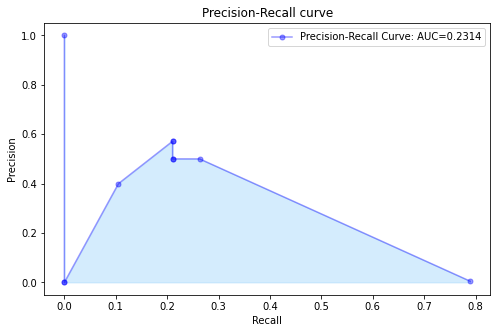

In [91]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(8, 5))
# plotting points as a scatter plot
plt.fill_between(rec, Prec, color='#95d0fc', alpha=0.4)
plt.plot(rec, Prec, label= "Precision-Recall Curve: AUC=%0.4f"%auc, color= "blue",
                marker= ".",markerfacecolor='blue', markersize=10, alpha=0.4)

# x-axis label
plt.xlabel('Recall')
# frequency label
plt.ylabel('Precision')
# plot title
plt.title('Precision-Recall curve')
# showing legend
plt.legend()

# function to show the plot
plt.show()

In [145]:
# import matplotlib.pyplot as plt

# fig=plt.figure(figsize=(8, 5))
# # plotting points as a scatter plot
# plt.fill_between(Prec, rec, color='#95d0fc', alpha=0.4)
# plt.plot(Prec, rec, label= "Precision-Recall Curve: AUC=%0.4f"%auc, color= "blue",
#                 marker= ".",markerfacecolor='blue', markersize=10, alpha=0.4)

# # x-axis label
# plt.xlabel('Precision')
# # frequency label
# plt.ylabel('Recall')
# # plot title
# plt.title('Precision-Recall curve')
# # showing legend
# plt.legend()

# # function to show the plot
# plt.show()

# Selection Best Threshold  == 0.10

In [92]:
DataFrame0  = pd.read_csv(f'/media/tohn/SSD/YOLOv4/model_p5/inference-yolov4-p5/PCI01/prostate_custom_PCI01.csv')
table = rebox(DataFrame0)
result_rebox = Get_1boxPre(table)
test_ = Get_1boxAct(test)
df_merge = map_table(test_, result_rebox)
result = fill_(df_merge)
Eva_table = EvaluationTeble(result, threshold_iou)
### Calculate perfermance matrix 
sum_TP = sum(list(Eva_table.TP))
sum_FP = sum(list(Eva_table.FP))
sum_FN = sum(list(Eva_table.FN))
sum_count = sum(list(Eva_table['count']))
sum_pred_count = sum(list(Eva_table.pred_count))
recall = sum_TP/(sum_TP+sum_FN)
precision = sum_TP/(sum_TP+sum_FP)

## Show Performance Result

In [93]:
IoU_pred = Eva_table['IoU_img'].tolist()
aa = []
for m in IoU_pred: 
    if m.shape[0] >1:
        a_ =[]
        for i in range(m.shape[1]):
            a = max(m[0][i],m[1][i])
            a_.append(float(a))
        a = np.mean(a_)
        aa.append(a)
    else:
        a = m.mean()
        aa.append(float(a))

print('\n', 'IoU :', aa)
print('\n', 'IoU Avg :', np.mean(aa))


 IoU : [0.04250159487128258, 0.41584157943725586, 0.0, 0.0, 0.0, 0.0, 0.3997619152069092, 0.13310293853282928, 0.6944983601570129, 0.5098248322804769]

 IoU Avg : 0.2195531220485767


In [94]:
print(f'True Positive ** SUM = {sum_TP}')
print(f'{list(Eva_table.TP)}')
print('-' * 50)
print(f'False  Positive ** SUM = {sum_FP}')
print(f'{list(Eva_table.FP)}')
print('-' * 50)
print(f'False Negative  ** SUM = {sum_FN}')
print(f'{list(Eva_table.FN)}\n')
print('-' * 50)
print(f'Precision ** : {precision}\n')
print(f'Recall ** : {recall}\n')
print('-' * 50)

print(f' Result Dataframe {Eva_table.shape}')
Eva_table

True Positive ** SUM = 5
[0, 1, 0, 0, 0, 0, 1, 0, 1, 2]
--------------------------------------------------
False  Positive ** SUM = 5
[1, 0, 0, 2, 0, 0, 1, 1, 0, 0]
--------------------------------------------------
False Negative  ** SUM = 14
[3, 1, 1, 1, 2, 1, 1, 3, 0, 1]

--------------------------------------------------
Precision ** : 0.5

Recall ** : 0.2631578947368421

--------------------------------------------------
 Result Dataframe (10, 16)


,fileName,Path,gt_xmin,gt_ymin,gt_xmax,gt_ymax,count,pred_xmin,pred_ymin,pred_xmax,pred_ymax,pred_count,IoU_img,TP,FP,FN
0,prostate_custom_191.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,"[468.0, 470.0, 351.0]","[309.0, 385.0, 374.0]","[549.0, 551.0, 390.0]","[367.0, 411.0, 432.0]",3,[454.9566],[347.976],[493.041],[392.976],1.0,"[[tensor(0.0840), tensor(0.0435), tensor(0.)]]",0,1,3
1,prostate_custom_194.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,"[385.0, 512.0]","[392.0, 362.0]","[442.0, 544.0]","[452.0, 403.0]",2,[386.9824],[394.0265],[446.0288],[448.0294],1.0,"[[tensor(0.8317), tensor(0.)]]",1,0,1
2,prostate_custom_196.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,[572.0],[408.0],[614.0],[501.0],1,[],[],[],[],0.0,[tensor(0.)],0,0,1
3,prostate_custom_197.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,[437.0],[382.0],[518.0],[430.0],1,"[382.9705, 498.9625]","[379.008, 294.984]","[426.02, 515.9675]","[428.976, 328.032]",2.0,"[[tensor(0.)], [tensor(0.)]]",0,2,1
4,prostate_custom_198.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,"[510.0, 527.0]","[436.0, 362.0]","[544.0, 553.0]","[475.0, 404.0]",2,[],[],[],[],0.0,[tensor(0.)],0,0,2
5,prostate_custom_200.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,[403.0],[208.0],[462.0],[240.0],1,[],[],[],[],0.0,[tensor(0.)],0,0,1
6,prostate_custom_201.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,"[413.0, 464.0]","[291.0, 294.0]","[445.0, 501.0]","[319.0, 327.0]",2,"[461.0358, 404.982]","[311.976, 292.032]","[505.0206, 452.9898]","[360.0, 322.992]",2.0,"[[tensor(0.), tensor(0.2126)], [tensor(0.5870)...",1,1,1
7,prostate_custom_203.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,"[437.0, 420.0, 411.0]","[313.0, 386.0, 250.0]","[475.0, 461.0, 458.0]","[359.0, 408.0, 293.0]",3,[444.994],[315.0],[510.9555],[356.976],1.0,"[[tensor(0.3993), tensor(0.), tensor(0.)]]",0,1,3
8,prostate_custom_206.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,[371.0],[352.0],[429.0],[404.0],1,[369.0432],[354.024],[429.0306],[391.032],1.0,[[tensor(0.6945)]],1,0,0
9,prostate_custom_207.jpg,/media/tohn/SSD/ProstateCancer/test/prostate_c...,"[363.0, 503.0, 447.0]","[312.0, 322.0, 407.0]","[410.0, 532.0, 512.0]","[372.0, 372.0, 439.0]",3,"[441.9936, 364.0368]","[406.008, 318.024]","[515.0334, 408.0216]","[436.968, 366.984]",2.0,"[[tensor(0.), tensor(0.), tensor(0.7805)], [te...",2,0,1


In [95]:
print(f'Number** Bbox Prediction TP : {int(sum(Eva_table.TP))}\n')
sum_count0 = sum(list(Eva_table['count']))
print(f'Number** Bbox ground Truth : {int(sum_count0)}')

Number** Bbox Prediction TP : 5

Number** Bbox ground Truth : 19


In [96]:
neg = np.array([[0, sum_FP]]) ## TN, FP 
pos = np.array([[sum_FN, sum_TP]]) ## FN, TP
cf_matrix = np.concatenate((neg, pos), axis=0)
cf_matrix
print(cf_matrix)
#labels = [‘True Neg’,’False Pos’,’False Neg’,’True Pos’]

[[ 0  5]
 [14  5]]


Text(0.5, 21.5, 'Predicted label')

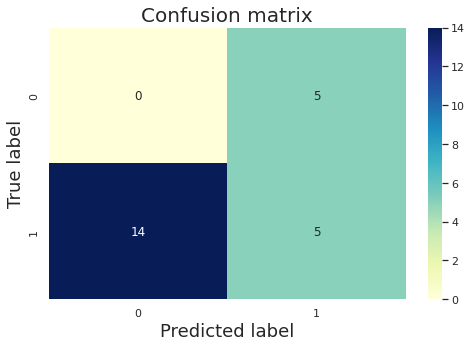

In [99]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

Text(0.5, 1.0, 'Confusion Matrix')

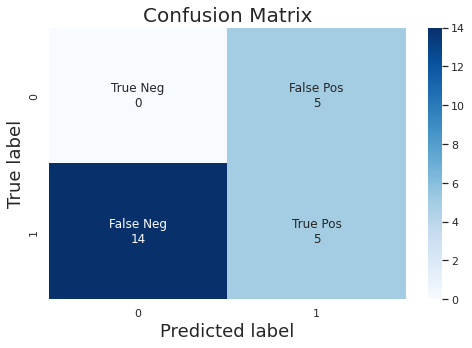

In [100]:
group_names = ['True Neg','False Pos','False Neg','True Pos' ]
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
#xyplotlabels = ['True Label' ,'Predicted Label']
# group_percentages = ['{0:.2%}'.format(value) for value in
#                      cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(8,5))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.ylabel('True label',fontsize=18)
plt.xlabel('Predicted label', fontsize=18)
plt.title('Confusion Matrix', fontsize=20)

# Plot img Prediction

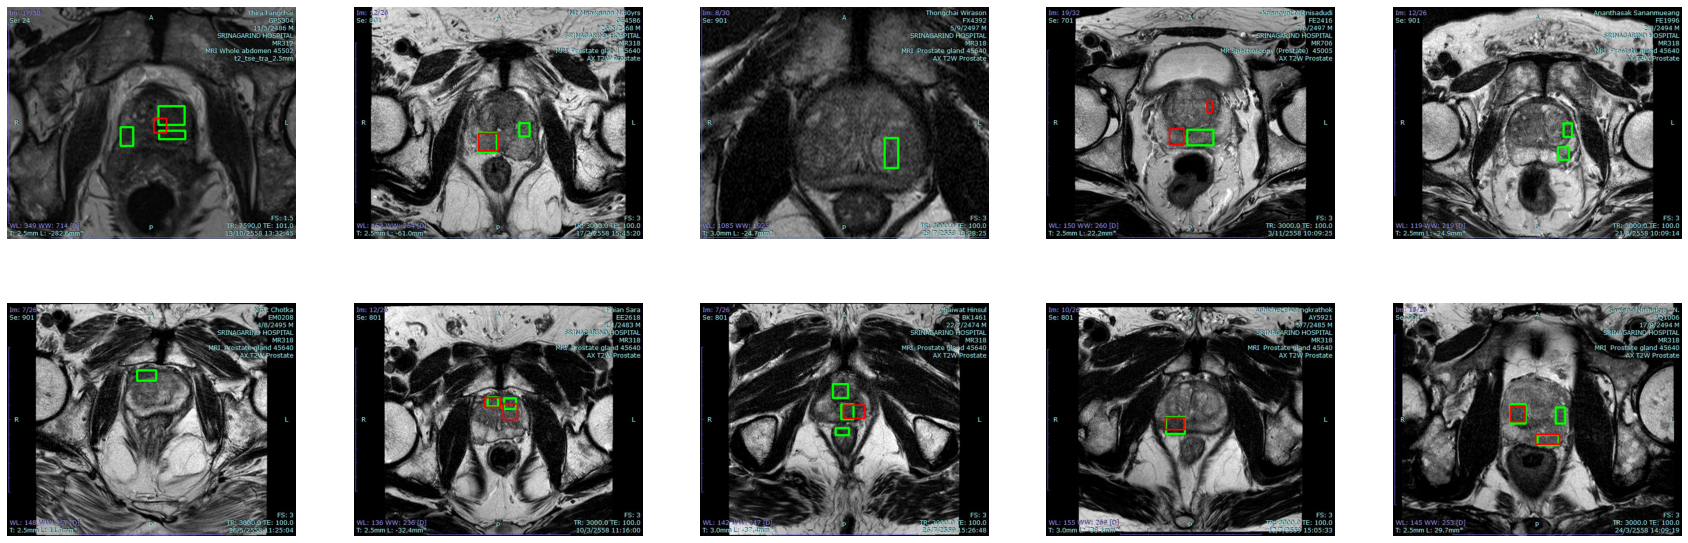

In [101]:
# Plot img Prediction
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False

res = Eva_table
w = 20
h = 20
fig = plt.figure(figsize=(30, 10))
columns = 5
rows = 2

fileName = Eva_table['fileName'].tolist()
for m in range(1, columns*rows +1):
    res = Eva_table[Eva_table['fileName'] ==fileName[m-1]]

    i = 0
    #load image origin save to test.jpg
    import cv2
    from IPython.display import Image
    img_path = res['Path'].tolist()[0]
    img_c = cv2.imread(img_path)

    for j in range(len(res['gt_xmin'].tolist()[i])):
        xmin_pre = int(res['gt_xmin'].tolist()[i][j])
        ymin_pre = int(res['gt_ymin'].tolist()[i][j])
        xmax_pre = int(res['gt_xmax'].tolist()[i][j])
        ymax_pre = int(res['gt_ymax'].tolist()[i][j])
        if j == 0:
            image_pre = cv2.rectangle(img_c, (xmin_pre ,ymin_pre), (xmax_pre, ymax_pre), (0,255,0), 6)
        else:
            image_pre = cv2.rectangle(image_pre, (xmin_pre ,ymin_pre), (xmax_pre, ymax_pre), (0,255,0), 6)

    for j in range(len(res['pred_xmin'].tolist()[i])):
        xmin_pre = int(res['pred_xmin'].tolist()[i][j])
        ymin_pre = int(res['pred_ymin'].tolist()[i][j])
        xmax_pre = int(res['pred_xmax'].tolist()[i][j])
        ymax_pre = int(res['pred_ymax'].tolist()[i][j])
        if j == 0:
            image_pre = cv2.rectangle(image_pre, (xmin_pre ,ymin_pre), (xmax_pre, ymax_pre), (255, 0, 0), 4)
        else:
            image_pre = cv2.rectangle(image_pre, (xmin_pre ,ymin_pre), (xmax_pre, ymax_pre), (255, 0, 0), 4)

    fig.add_subplot(rows, columns, m)
    plt.imshow(image_pre)
    plt.axis('off')
        
plt.show()